# One-to-Many Face Recognition Authentication System

This notebook implements a comprehensive face recognition authentication system using DeepFace library with:
- **Primary Model**: GhostFaceNet
- **Fallback Model**: FaceNet
- **Database**: JSON-based storage
- **Pipeline**: Face detection → Alignment → Augmentation → Embedding → Recognition

## Features:
1. Configurable models and face alignment algorithms
2. Image augmentation with lighting variations
3. Embedding storage in JSON database
4. Top-5 similarity matching with distance scores
5. Comprehensive logging and evaluation metrics

In [3]:
# Import required libraries
import os
import json
import numpy as np
import cv2
from pathlib import Path
from datetime import datetime
import logging
from typing import Dict, List, Tuple, Optional, Any
import warnings
warnings.filterwarnings('ignore')

# DeepFace imports
from deepface import DeepFace
from deepface.modules import detection, representation, modeling

# Data science libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully!")
print(f"DeepFace version: {DeepFace.__version__ if hasattr(DeepFace, '__version__') else 'Not available'}")

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

Libraries imported successfully!
DeepFace version: 0.0.93


In [4]:
# Configuration class for easy model and algorithm changes
class FaceRecognitionConfig:
    def __init__(self):
        # Model configurations
        self.primary_model = "GhostFaceNet"
        self.fallback_model = "Facenet"
        
        # Face detection backends (easily changeable)
        self.primary_detector = "retinaface"  # Options: opencv, ssd, dlib, mtcnn, retinaface, mediapipe
        self.fallback_detector = "mtcnn"
        
        # Face alignment algorithms
        self.alignment_algorithm = True  # Enable face alignment
        
        # Distance metrics
        self.distance_metric = "cosine"  # Options: cosine, euclidean, euclidean_l2
        
        # Augmentation parameters
        self.lighting_variations = [0.7, 0.8, 0.9, 1.1, 1.2, 1.3]  # Brightness multipliers
        self.enable_augmentation = True
        
        # Thresholds
        self.similarity_threshold = 0.68  # Cosine distance threshold
        self.top_k_matches = 5
        
        # Paths
        self.database_path = "face_database"
        self.query_path = "sample_images"
        self.json_db_file = "face_embeddings_db.json"
        self.results_file = "recognition_results.json"
        
        # Logging
        self.log_level = logging.INFO

# Initialize configuration
config = FaceRecognitionConfig()

print("Configuration initialized:")
print(f"Primary Model: {config.primary_model}")
print(f"Fallback Model: {config.fallback_model}")
print(f"Primary Detector: {config.primary_detector}")
print(f"Distance Metric: {config.distance_metric}")
print(f"Augmentation Enabled: {config.enable_augmentation}")
print(f"Top K Matches: {config.top_k_matches}")
print(f"Database Path: {config.database_path}")
print(f"Query Path: {config.query_path}")

Configuration initialized:
Primary Model: GhostFaceNet
Fallback Model: Facenet
Primary Detector: retinaface
Distance Metric: cosine
Augmentation Enabled: True
Top K Matches: 5
Database Path: face_database
Query Path: sample_images


In [5]:
# Utility functions for face processing
class FaceProcessor:
    def __init__(self, config: FaceRecognitionConfig):
        self.config = config
        self.logger = logging.getLogger(__name__)
    
    def adjust_lighting(self, image: np.ndarray, brightness_factor: float) -> np.ndarray:
        """Apply lighting variation to image"""
        adjusted = cv2.convertScaleAbs(image, alpha=brightness_factor, beta=0)
        return adjusted
    
    def generate_augmented_images(self, image_path: str) -> List[Tuple[np.ndarray, str]]:
        """Generate augmented versions of the image with different lighting"""
        try:
            # Read original image
            original_img = cv2.imread(image_path)
            if original_img is None:
                self.logger.error(f"Failed to load image: {image_path}")
                return []
            
            augmented_images = [(original_img, "original")]
            
            if self.config.enable_augmentation:
                for i, brightness in enumerate(self.config.lighting_variations):
                    augmented_img = self.adjust_lighting(original_img, brightness)
                    augmented_images.append((augmented_img, f"brightness_{brightness}"))
            
            return augmented_images
            
        except Exception as e:
            self.logger.error(f"Error generating augmented images for {image_path}: {e}")
            return []
    
    def get_face_embedding(self, image_input, model_name: str, detector_backend: str) -> Optional[List[float]]:
        """Generate face embedding with error handling"""
        try:
            # Handle different input types
            if isinstance(image_input, str):
                # File path
                result = DeepFace.represent(
                    img_path=image_input,
                    model_name=model_name,
                    detector_backend=detector_backend,
                    align=self.config.alignment_algorithm,
                    enforce_detection=False
                )
            else:
                # NumPy array
                result = DeepFace.represent(
                    img_path=image_input,
                    model_name=model_name,
                    detector_backend=detector_backend,
                    align=self.config.alignment_algorithm,
                    enforce_detection=False
                )
            
            if result and len(result) > 0:
                return result[0]["embedding"]
            return None
            
        except Exception as e:
            self.logger.warning(f"Failed to generate embedding with {model_name}/{detector_backend}: {e}")
            return None
    
    def get_robust_embedding(self, image_input) -> Optional[Dict[str, Any]]:
        """Get embedding with primary model, fallback to secondary if needed"""
        # Try primary model first
        embedding = self.get_face_embedding(
            image_input, 
            self.config.primary_model, 
            self.config.primary_detector
        )
        
        embedding_info = {
            "embedding": embedding,
            "model_used": self.config.primary_model,
            "detector_used": self.config.primary_detector,
            "fallback_used": False
        }
        
        # If primary fails, try fallback
        if embedding is None:
            self.logger.info("Primary model failed, trying fallback...")
            embedding = self.get_face_embedding(
                image_input, 
                self.config.fallback_model, 
                self.config.fallback_detector
            )
            
            if embedding is not None:
                embedding_info.update({
                    "embedding": embedding,
                    "model_used": self.config.fallback_model,
                    "detector_used": self.config.fallback_detector,
                    "fallback_used": True
                })
        
        return embedding_info if embedding is not None else None

# Initialize face processor
face_processor = FaceProcessor(config)
print("Face processor initialized successfully!")

Face processor initialized successfully!


In [6]:
# Database management for JSON storage
class FaceDatabase:
    def __init__(self, config: FaceRecognitionConfig):
        self.config = config
        self.db_file = config.json_db_file
        self.logger = logging.getLogger(__name__)
        self.database = self.load_database()
    
    def load_database(self) -> Dict[str, Any]:
        """Load existing database or create new one"""
        if os.path.exists(self.db_file):
            try:
                with open(self.db_file, 'r') as f:
                    db = json.load(f)
                self.logger.info(f"Loaded existing database with {len(db.get('persons', {}))} persons")
                return db
            except Exception as e:
                self.logger.error(f"Error loading database: {e}")
        
        # Create new database structure
        return {
            "metadata": {
                "created": datetime.now().isoformat(),
                "last_updated": datetime.now().isoformat(),
                "primary_model": self.config.primary_model,
                "fallback_model": self.config.fallback_model,
                "detector_backend": self.config.primary_detector,
                "distance_metric": self.config.distance_metric,
                "total_persons": 0,
                "total_embeddings": 0
            },
            "persons": {}
        }
    
    def save_database(self):
        """Save database to JSON file"""
        try:
            self.database["metadata"]["last_updated"] = datetime.now().isoformat()
            self.database["metadata"]["total_persons"] = len(self.database["persons"])
            
            total_embeddings = sum(
                len(person_data.get("embeddings", []))
                for person_data in self.database["persons"].values()
            )
            self.database["metadata"]["total_embeddings"] = total_embeddings
            
            with open(self.db_file, 'w') as f:
                json.dump(self.database, f, indent=2)
            
            self.logger.info(f"Database saved with {self.database['metadata']['total_persons']} persons "
                           f"and {total_embeddings} embeddings")
            
        except Exception as e:
            self.logger.error(f"Error saving database: {e}")
    
    def add_person_embedding(self, person_id: str, image_info: Dict[str, Any], embedding_info: Dict[str, Any]):
        """Add embedding for a person"""
        if person_id not in self.database["persons"]:
            self.database["persons"][person_id] = {
                "person_id": person_id,
                "embeddings": [],
                "images_processed": 0,
                "augmentations_created": 0
            }
        
        embedding_record = {
            "embedding_id": f"{person_id}_{len(self.database['persons'][person_id]['embeddings'])}",
            "image_path": image_info["image_path"],
            "augmentation_type": image_info["augmentation_type"],
            "embedding": embedding_info["embedding"],
            "model_used": embedding_info["model_used"],
            "detector_used": embedding_info["detector_used"],
            "fallback_used": embedding_info["fallback_used"],
            "created_at": datetime.now().isoformat(),
            "embedding_dimension": len(embedding_info["embedding"])
        }
        
        self.database["persons"][person_id]["embeddings"].append(embedding_record)
        
        if image_info["augmentation_type"] == "original":
            self.database["persons"][person_id]["images_processed"] += 1
        else:
            self.database["persons"][person_id]["augmentations_created"] += 1
    
    def get_all_embeddings(self) -> List[Dict[str, Any]]:
        """Get all embeddings from database"""
        all_embeddings = []
        for person_id, person_data in self.database["persons"].items():
            for embedding_record in person_data.get("embeddings", []):
                embedding_record["person_id"] = person_id
                all_embeddings.append(embedding_record)
        return all_embeddings
    
    def get_person_embeddings(self, person_id: str) -> List[Dict[str, Any]]:
        """Get all embeddings for a specific person"""
        if person_id in self.database["persons"]:
            return self.database["persons"][person_id].get("embeddings", [])
        return []

# Initialize database
face_db = FaceDatabase(config)
print(f"Database initialized. Current stats:")
print(f"- Total persons: {face_db.database['metadata']['total_persons']}")
print(f"- Total embeddings: {face_db.database['metadata']['total_embeddings']}")
print(f"- Database file: {face_db.db_file}")

Database initialized. Current stats:
- Total persons: 0
- Total embeddings: 0
- Database file: face_embeddings_db.json


In [ ]:
# Step 1: Scan for user folders and discover person directories
def scan_person_folders(base_path: str) -> Dict[str, List[str]]:
    """Scan for person folders and their images"""
    person_data = {}
    base_path = Path(base_path)
    
    if not base_path.exists():
        logging.error(f"Database path does not exist: {base_path}")
        return {}
    
    # Look for person directories
    for person_dir in base_path.iterdir():
        if person_dir.is_dir() and person_dir.name.startswith(('person', 'user')):
            person_id = person_dir.name
            image_files = []
            
            # Find image files in person directory
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']:
                image_files.extend(person_dir.glob(ext))
            
            if image_files:
                person_data[person_id] = [str(img) for img in image_files]
                logging.info(f"Found {len(image_files)} images for {person_id}")
    
    return person_data

# Discover person folders and images
print("=== STEP 1: SCANNING FOR USER FOLDERS ===")
person_folders = scan_person_folders(config.database_path)

if person_folders:
    print(f"\\nFound {len(person_folders)} person folders:")
    for person_id, images in person_folders.items():
        print(f"  - {person_id}: {len(images)} images")
        for img in images[:3]:  # Show first 3 images
            print(f"    • {Path(img).name}")
        if len(images) > 3:
            print(f"    • ... and {len(images) - 3} more")
else:
    print("No person folders found. Creating sample structure...")
    # Note: In real scenario, you would create or point to existing folders
    print("Please ensure your face_database folder contains person subdirectories with images.")

2025-07-24 23:42:44,469 - INFO - Found 6 images for person1
2025-07-24 23:42:44,471 - INFO - Found 4 images for person2
2025-07-24 23:42:44,473 - INFO - Found 4 images for person3
2025-07-24 23:42:44,471 - INFO - Found 4 images for person2
2025-07-24 23:42:44,473 - INFO - Found 4 images for person3


=== STEP 1: SCANNING FOR USER FOLDERS ===
\nFound 3 person folders:
  - person1: 6 images
    • person1_1.jpg
    • person1_2.jpg
    • person1_3.jpg
    • ... and 3 more
  - person2: 4 images
    • person2_1.jpg
    • person2_2.jpg
    • person2_1.jpg
    • ... and 1 more
  - person3: 4 images
    • person3_1.jpg
    • person3_2.jpg
    • person3_1.jpg
    • ... and 1 more


In [15]:
# Steps 2-4: Process images, align, augment and create embeddings
def process_person_images(person_id: str, image_paths: List[str]) -> Dict[str, Any]:
    """Process all images for a person: align, augment, and create embeddings"""
    results = {
        "person_id": person_id,
        "processed_images": 0,
        "failed_images": 0,
        "total_embeddings": 0,
        "original_embeddings": 0,
        "augmented_embeddings": 0,
        "processing_details": []
    }
    
    for img_path in image_paths:
        try:
            logging.info(f"Processing {Path(img_path).name} for {person_id}")
            
            # Generate augmented versions (includes original)
            augmented_images = face_processor.generate_augmented_images(img_path)
            
            if not augmented_images:
                results["failed_images"] += 1
                continue
            
            image_embeddings = 0
            
            # Process each augmented version
            for img_array, aug_type in augmented_images:
                # Create embedding with robust fallback
                embedding_info = face_processor.get_robust_embedding(img_array)
                
                if embedding_info and embedding_info["embedding"] is not None:
                    # Store in database
                    image_info = {
                        "image_path": img_path,
                        "augmentation_type": aug_type
                    }
                    
                    face_db.add_person_embedding(person_id, image_info, embedding_info)
                    
                    image_embeddings += 1
                    results["total_embeddings"] += 1
                    
                    if aug_type == "original":
                        results["original_embeddings"] += 1
                    else:
                        results["augmented_embeddings"] += 1
            
            if image_embeddings > 0:
                results["processed_images"] += 1
                results["processing_details"].append({
                    "image": Path(img_path).name,
                    "embeddings_created": image_embeddings,
                    "augmentations": len(augmented_images) - 1
                })
            else:
                results["failed_images"] += 1
                
        except Exception as e:
            logging.error(f"Error processing {img_path}: {e}")
            results["failed_images"] += 1
    
    return results

# Process all discovered persons
print("\\n=== STEPS 2-4: PROCESSING IMAGES (ALIGN + AUGMENT + EMBED) ===")

if person_folders:
    all_processing_results = {}
    
    for person_id, image_paths in person_folders.items():
        print(f"\\nProcessing {person_id}...")
        
        # Process person's images
        processing_results = process_person_images(person_id, image_paths)
        all_processing_results[person_id] = processing_results
        
        # Display results
        print(f"  ✓ Images processed: {processing_results['processed_images']}/{len(image_paths)}")
        print(f"  ✓ Total embeddings: {processing_results['total_embeddings']}")
        print(f"  ✓ Original embeddings: {processing_results['original_embeddings']}")
        print(f"  ✓ Augmented embeddings: {processing_results['augmented_embeddings']}")
        
        if processing_results['failed_images'] > 0:
            print(f"  ⚠ Failed images: {processing_results['failed_images']}")
    
    # Save database
    face_db.save_database()
    
    # Summary
    total_processed = sum(r['processed_images'] for r in all_processing_results.values())
    total_embeddings = sum(r['total_embeddings'] for r in all_processing_results.values())
    total_failed = sum(r['failed_images'] for r in all_processing_results.values())
    
    print(f"\\n📊 PROCESSING SUMMARY:")
    print(f"  • Total persons: {len(person_folders)}")
    print(f"  • Images processed: {total_processed}")
    print(f"  • Images failed: {total_failed}")
    print(f"  • Total embeddings created: {total_embeddings}")
    print(f"  • Database saved to: {config.json_db_file}")
    
else:
    print("No person folders to process. Please ensure face_database contains person directories.")

2025-07-24 23:42:54,459 - INFO - Processing person1_1.jpg for person1


\n=== STEPS 2-4: PROCESSING IMAGES (ALIGN + AUGMENT + EMBED) ===
\nProcessing person1...
25-07-24 23:42:57 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
25-07-24 23:42:57 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: C:\Users\aroyy\.deepface\weights\retinaface.h5
100%|██████████| 119M/119M [00:13<00:00, 8.99MB/s] 

2025-07-24 23:43:15,981 - INFO - Processing person1_2.jpg for person1
2025-07-24 23:43:15,981 - INFO - Processing person1_2.jpg for person1
2025-07-24 23:43:20,695 - INFO - Processing person1_3.jpg for person1
2025-07-24 23:43:20,695 - INFO - Processing person1_3.jpg for person1
2025-07-24 23:43:25,698 - INFO - Processing person1_1.jpg for person1
2025-07-24 23:43:25,698 - INFO - Processing person1_1.jpg for person1
2025-07-24 23:43:29,233 - INFO - Processing person1_2.jpg for person1
2025-07-24 23:43:29,233 - INFO - Processing person1_2.jpg for person1
2025-07-24 23:43:33,934 - INFO - Processing person1_3.jpg for person1
2025-07-24 23:43:33,934 - INFO - Processing person1_3.jpg for person1
2025-07-24 23:43:38,768 - INFO - Processing person2_1.jpg for person2
2025-07-24 23:43:38,768 

  ✓ Images processed: 6/6
  ✓ Total embeddings: 42
  ✓ Original embeddings: 6
  ✓ Augmented embeddings: 36
\nProcessing person2...


2025-07-24 23:43:49,306 - INFO - Processing person2_2.jpg for person2
2025-07-24 23:43:54,789 - INFO - Processing person2_1.jpg for person2
2025-07-24 23:43:54,789 - INFO - Processing person2_1.jpg for person2
2025-07-24 23:44:05,239 - INFO - Processing person2_2.jpg for person2
2025-07-24 23:44:05,239 - INFO - Processing person2_2.jpg for person2
2025-07-24 23:44:10,424 - INFO - Processing person3_1.jpg for person3
2025-07-24 23:44:10,424 - INFO - Processing person3_1.jpg for person3


  ✓ Images processed: 4/4
  ✓ Total embeddings: 28
  ✓ Original embeddings: 4
  ✓ Augmented embeddings: 24
\nProcessing person3...


2025-07-24 23:44:15,704 - INFO - Processing person3_2.jpg for person3
2025-07-24 23:44:20,397 - INFO - Processing person3_1.jpg for person3
2025-07-24 23:44:20,397 - INFO - Processing person3_1.jpg for person3
2025-07-24 23:44:25,654 - INFO - Processing person3_2.jpg for person3
2025-07-24 23:44:25,654 - INFO - Processing person3_2.jpg for person3
2025-07-24 23:44:30,510 - INFO - Database saved with 3 persons and 98 embeddings
2025-07-24 23:44:30,510 - INFO - Database saved with 3 persons and 98 embeddings


  ✓ Images processed: 4/4
  ✓ Total embeddings: 28
  ✓ Original embeddings: 4
  ✓ Augmented embeddings: 24
\n📊 PROCESSING SUMMARY:
  • Total persons: 3
  • Images processed: 14
  • Images failed: 0
  • Total embeddings created: 98
  • Database saved to: face_embeddings_db.json


In [16]:
# Face recognition and similarity matching
class FaceRecognizer:
    def __init__(self, config: FaceRecognitionConfig, face_processor: FaceProcessor, database: FaceDatabase):
        self.config = config
        self.face_processor = face_processor
        self.database = database
        self.logger = logging.getLogger(__name__)
    
    def calculate_distance(self, embedding1: List[float], embedding2: List[float]) -> float:
        """Calculate distance between two embeddings"""
        try:
            if self.config.distance_metric == "cosine":
                # Cosine distance
                dot_product = np.dot(embedding1, embedding2)
                norm1 = np.linalg.norm(embedding1)
                norm2 = np.linalg.norm(embedding2)
                cosine_similarity = dot_product / (norm1 * norm2)
                return 1 - cosine_similarity
            
            elif self.config.distance_metric == "euclidean":
                return np.linalg.norm(np.array(embedding1) - np.array(embedding2))
            
            elif self.config.distance_metric == "euclidean_l2":
                distance = np.linalg.norm(np.array(embedding1) - np.array(embedding2))
                return distance / np.sqrt(len(embedding1))
            
        except Exception as e:
            self.logger.error(f"Error calculating distance: {e}")
            return float('inf')
    
    def find_best_matches(self, query_embedding: List[float]) -> List[Dict[str, Any]]:
        """Find best matching persons with similarity scores"""
        all_embeddings = self.database.get_all_embeddings()
        
        if not all_embeddings:
            self.logger.warning("No embeddings in database for matching")
            return []
        
        matches = []
        
        for db_embedding in all_embeddings:
            try:
                distance = self.calculate_distance(query_embedding, db_embedding["embedding"])
                
                match_info = {
                    "person_id": db_embedding["person_id"],
                    "embedding_id": db_embedding["embedding_id"],
                    "distance": distance,
                    "similarity_score": 1 - distance if self.config.distance_metric == "cosine" else 1 / (1 + distance),
                    "model_used": db_embedding["model_used"],
                    "detector_used": db_embedding["detector_used"],
                    "image_path": db_embedding["image_path"],
                    "augmentation_type": db_embedding["augmentation_type"],
                    "fallback_used": db_embedding["fallback_used"]
                }
                
                matches.append(match_info)
                
            except Exception as e:
                self.logger.error(f"Error matching with embedding {db_embedding.get('embedding_id', 'unknown')}: {e}")
        
        # Sort by distance (ascending for distance metrics)
        matches.sort(key=lambda x: x["distance"])
        
        # Group by person and get best match per person
        person_best_matches = {}
        for match in matches:
            person_id = match["person_id"]
            if person_id not in person_best_matches or match["distance"] < person_best_matches[person_id]["distance"]:
                person_best_matches[person_id] = match
        
        # Convert back to list and sort
        best_matches = list(person_best_matches.values())
        best_matches.sort(key=lambda x: x["distance"])
        
        return best_matches[:self.config.top_k_matches]
    
    def recognize_face(self, query_image_path: str) -> Dict[str, Any]:
        """Recognize face in query image"""
        try:
            self.logger.info(f"Recognizing face in: {Path(query_image_path).name}")
            
            # Generate embedding for query image
            embedding_info = self.face_processor.get_robust_embedding(query_image_path)
            
            if not embedding_info or embedding_info["embedding"] is None:
                return {
                    "success": False,
                    "error": "Failed to generate embedding for query image",
                    "query_image": query_image_path
                }
            
            # Find best matches
            matches = self.find_best_matches(embedding_info["embedding"])
            
            # Determine if there's a valid match based on threshold
            valid_matches = [m for m in matches if m["distance"] <= self.config.similarity_threshold]
            
            result = {
                "success": True,
                "query_image": query_image_path,
                "query_embedding_info": {
                    "model_used": embedding_info["model_used"],
                    "detector_used": embedding_info["detector_used"],
                    "fallback_used": embedding_info["fallback_used"],
                    "embedding_dimension": len(embedding_info["embedding"])
                },
                "total_matches_found": len(matches),
                "valid_matches_count": len(valid_matches),
                "top_matches": matches,
                "best_match": matches[0] if matches else None,
                "is_recognized": len(valid_matches) > 0,
                "confidence": matches[0]["similarity_score"] if matches else 0.0,
                "processing_timestamp": datetime.now().isoformat()
            }
            
            return result
            
        except Exception as e:
            self.logger.error(f"Error recognizing face in {query_image_path}: {e}")
            return {
                "success": False,
                "error": str(e),
                "query_image": query_image_path,
                "processing_timestamp": datetime.now().isoformat()
            }

# Initialize face recognizer
face_recognizer = FaceRecognizer(config, face_processor, face_db)
print("Face recognizer initialized successfully!")

Face recognizer initialized successfully!


In [ ]:
# Step 5: Process query images and perform face recognition
def process_query_images(query_folder: str) -> List[Dict[str, Any]]:
    """Process all query images and perform face recognition"""
    query_path = Path(query_folder)
    recognition_results = []
    
    if not query_path.exists():
        logging.error(f"Query folder does not exist: {query_path}")
        return []
    
    # Find all image files in query folder and subfolders
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    query_images = []
    
    for ext in image_extensions:
        query_images.extend(query_path.rglob(ext))
    
    if not query_images:
        logging.warning(f"No images found in query folder: {query_path}")
        return []
    
    logging.info(f"Found {len(query_images)} query images to process")
    
    # Process each query image
    for img_path in query_images:
        try:
            result = face_recognizer.recognize_face(str(img_path))
            recognition_results.append(result)
            
            # Log result summary
            if result["success"]:
                if result["is_recognized"]:
                    best_match = result["best_match"]
                    logging.info(f"✓ {Path(img_path).name} -> {best_match['person_id']} "
                               f"(confidence: {result['confidence']:.3f}, distance: {best_match['distance']:.3f})")
                else:
                    logging.info(f"? {Path(img_path).name} -> No valid match found")
            else:
                logging.error(f"✗ {Path(img_path).name} -> Processing failed: {result.get('error', 'Unknown error')}")
                
        except Exception as e:
            logging.error(f"Error processing query image {img_path}: {e}")
            recognition_results.append({
                "success": False,
                "error": str(e),
                "query_image": str(img_path),
                "processing_timestamp": datetime.now().isoformat()
            })
    
    return recognition_results

# Execute Step 5: Face Recognition
print("\\n=== STEP 5: FACE RECOGNITION ON QUERY IMAGES ===")

# Check if we have embeddings in database
all_embeddings = face_db.get_all_embeddings()
if not all_embeddings:
    print("❌ No embeddings found in database. Please run the image processing steps first.")
else:
    print(f"✓ Found {len(all_embeddings)} embeddings in database for {len(face_db.database['persons'])} persons")
    
    # Process query images
    print(f"\\nProcessing query images from: {config.query_path}")
    recognition_results = process_query_images(config.query_path)
    
    if recognition_results:
        # Display results summary
        successful_recognitions = [r for r in recognition_results if r["success"]]
        failed_recognitions = [r for r in recognition_results if not r["success"]]
        recognized_faces = [r for r in successful_recognitions if r["is_recognized"]]
        unrecognized_faces = [r for r in successful_recognitions if not r["is_recognized"]]
        
        print(f"\\n📊 RECOGNITION RESULTS SUMMARY:")
        print(f"  • Total query images: {len(recognition_results)}")
        print(f"  • Successfully processed: {len(successful_recognitions)}")
        print(f"  • Processing failures: {len(failed_recognitions)}")
        print(f"  • Faces recognized: {len(recognized_faces)}")
        print(f"  • Faces not recognized: {len(unrecognized_faces)}")
        
        # Show top results
        if recognized_faces:
            print(f"\\n🎯 TOP RECOGNITION RESULTS:")
            # Sort by confidence
            top_results = sorted(recognized_faces, key=lambda x: x["confidence"], reverse=True)[:5]
            
            for i, result in enumerate(top_results, 1):
                best_match = result["best_match"]
                query_name = Path(result["query_image"]).name
                print(f"  {i}. {query_name}")
                print(f"     → Identified as: {best_match['person_id']}")
                print(f"     → Confidence: {result['confidence']:.3f}")
                print(f"     → Distance: {best_match['distance']:.3f}")
                print(f"     → Model: {result['query_embedding_info']['model_used']}")
        
        # Store results for Step 6
        globals()['recognition_results'] = recognition_results
        
    else:
        print("No query images found or processed.")

2025-07-24 23:45:31,793 - INFO - Found 36 query images to process
2025-07-24 23:45:31,798 - INFO - Recognizing face in: 20250630_175850.jpg
2025-07-24 23:45:31,798 - INFO - Recognizing face in: 20250630_175850.jpg


\n=== STEP 5: FACE RECOGNITION ON QUERY IMAGES ===
✓ Found 98 embeddings in database for 3 persons
\nProcessing query images from: sample_images


2025-07-24 23:45:33,712 - INFO - ? 20250630_175850.jpg -> No valid match found
2025-07-24 23:45:33,715 - INFO - Recognizing face in: 20250701_182222.jpg
2025-07-24 23:45:33,715 - INFO - Recognizing face in: 20250701_182222.jpg
2025-07-24 23:45:35,568 - INFO - ✓ 20250701_182222.jpg -> person1 (confidence: 0.494, distance: 0.506)
2025-07-24 23:45:35,568 - INFO - Recognizing face in: 20250701_182417.jpg
2025-07-24 23:45:35,568 - INFO - ✓ 20250701_182222.jpg -> person1 (confidence: 0.494, distance: 0.506)
2025-07-24 23:45:35,568 - INFO - Recognizing face in: 20250701_182417.jpg
2025-07-24 23:45:37,458 - INFO - ? 20250701_182417.jpg -> No valid match found
2025-07-24 23:45:37,458 - INFO - Recognizing face in: 20250705_023914.jpg
2025-07-24 23:45:37,458 - INFO - ? 20250701_182417.jpg -> No valid match found
2025-07-24 23:45:37,458 - INFO - Recognizing face in: 20250705_023914.jpg
2025-07-24 23:45:41,486 - INFO - ? 20250705_023914.jpg -> No valid match found
2025-07-24 23:45:41,486 - INFO - R

\n📊 RECOGNITION RESULTS SUMMARY:
  • Total query images: 36
  • Successfully processed: 36
  • Processing failures: 0
  • Faces recognized: 10
  • Faces not recognized: 26
\n🎯 TOP RECOGNITION RESULTS:
  1. covAA-04.jpg
     → Identified as: person2
     → Confidence: 0.617
     → Distance: 0.383
     → Model: GhostFaceNet
  2. covAA-04.jpg
     → Identified as: person2
     → Confidence: 0.617
     → Distance: 0.383
     → Model: GhostFaceNet
  3. 20250708_162645.jpg
     → Identified as: person1
     → Confidence: 0.523
     → Distance: 0.477
     → Model: GhostFaceNet
  4. 20250708_162645.jpg
     → Identified as: person1
     → Confidence: 0.523
     → Distance: 0.477
     → Model: GhostFaceNet
  5. 20250701_182222.jpg
     → Identified as: person1
     → Confidence: 0.494
     → Distance: 0.506
     → Model: GhostFaceNet


In [22]:
# Step 6: Generate comprehensive evaluation and results summary
class ResultsAnalyzer:
    def __init__(self, config: FaceRecognitionConfig):
        self.config = config
        self.logger = logging.getLogger(__name__)
    
    def generate_evaluation_summary(self, recognition_results: List[Dict[str, Any]], 
                                   face_database: FaceDatabase) -> Dict[str, Any]:
        """Generate comprehensive evaluation summary"""
        
        # Basic statistics
        total_queries = len(recognition_results)
        successful_processing = [r for r in recognition_results if r["success"]]
        failed_processing = [r for r in recognition_results if not r["success"]]
        recognized_faces = [r for r in successful_processing if r["is_recognized"]]
        unrecognized_faces = [r for r in successful_processing if not r["is_recognized"]]
        
        # Model usage statistics
        model_usage = {}
        fallback_usage = 0
        for result in successful_processing:
            model = result["query_embedding_info"]["model_used"]
            model_usage[model] = model_usage.get(model, 0) + 1
            if result["query_embedding_info"]["fallback_used"]:
                fallback_usage += 1
        
        # Confidence distribution
        confidences = [r["confidence"] for r in recognized_faces]
        distances = [r["best_match"]["distance"] for r in recognized_faces]
        
        # Person recognition breakdown
        person_recognition = {}
        for result in recognized_faces:
            person_id = result["best_match"]["person_id"]
            if person_id not in person_recognition:
                person_recognition[person_id] = {
                    "recognized_count": 0,
                    "total_queries": 0,
                    "avg_confidence": 0,
                    "avg_distance": 0,
                    "confidences": [],
                    "distances": []
                }
            person_recognition[person_id]["recognized_count"] += 1
            person_recognition[person_id]["confidences"].append(result["confidence"])
            person_recognition[person_id]["distances"].append(result["best_match"]["distance"])
        
        # Calculate averages for each person
        for person_id, stats in person_recognition.items():
            stats["avg_confidence"] = np.mean(stats["confidences"])
            stats["avg_distance"] = np.mean(stats["distances"])
            # Note: total_queries would need ground truth data for accuracy calculation
        
        # Database statistics
        db_stats = face_database.database["metadata"]
        
        evaluation_summary = {
            "evaluation_metadata": {
                "evaluation_timestamp": datetime.now().isoformat(),
                "configuration": {
                    "primary_model": self.config.primary_model,
                    "fallback_model": self.config.fallback_model,
                    "primary_detector": self.config.primary_detector,
                    "distance_metric": self.config.distance_metric,
                    "similarity_threshold": self.config.similarity_threshold,
                    "top_k_matches": self.config.top_k_matches,
                    "augmentation_enabled": self.config.enable_augmentation
                }
            },
            
            "processing_statistics": {
                "total_query_images": total_queries,
                "successfully_processed": len(successful_processing),
                "processing_failures": len(failed_processing),
                "processing_success_rate": len(successful_processing) / total_queries if total_queries > 0 else 0
            },
            
            "recognition_statistics": {
                "faces_recognized": len(recognized_faces),
                "faces_unrecognized": len(unrecognized_faces),
                "recognition_rate": len(recognized_faces) / len(successful_processing) if successful_processing else 0,
                "overall_success_rate": len(recognized_faces) / total_queries if total_queries > 0 else 0
            },
            
            "model_performance": {
                "model_usage_distribution": model_usage,
                "fallback_usage_count": fallback_usage,
                "fallback_usage_rate": fallback_usage / len(successful_processing) if successful_processing else 0
            },
            
            "confidence_analysis": {
                "mean_confidence": np.mean(confidences) if confidences else 0,
                "median_confidence": np.median(confidences) if confidences else 0,
                "std_confidence": np.std(confidences) if confidences else 0,
                "min_confidence": np.min(confidences) if confidences else 0,
                "max_confidence": np.max(confidences) if confidences else 0,
                "confidence_distribution": {
                    "very_high (>0.9)": len([c for c in confidences if c > 0.9]),
                    "high (0.8-0.9)": len([c for c in confidences if 0.8 <= c <= 0.9]),
                    "medium (0.7-0.8)": len([c for c in confidences if 0.7 <= c < 0.8]),
                    "low (0.6-0.7)": len([c for c in confidences if 0.6 <= c < 0.7]),
                    "very_low (<0.6)": len([c for c in confidences if c < 0.6])
                }
            },
            
            "distance_analysis": {
                "mean_distance": np.mean(distances) if distances else 0,
                "median_distance": np.median(distances) if distances else 0,
                "std_distance": np.std(distances) if distances else 0,
                "min_distance": np.min(distances) if distances else 0,
                "max_distance": np.max(distances) if distances else 0
            },
            
            "per_person_performance": person_recognition,
            
            "database_statistics": {
                "total_persons_in_db": db_stats["total_persons"],
                "total_embeddings_in_db": db_stats["total_embeddings"],
                "avg_embeddings_per_person": db_stats["total_embeddings"] / db_stats["total_persons"] if db_stats["total_persons"] > 0 else 0
            },
            
            "detailed_results": recognition_results
        }
        
        return evaluation_summary
    
    def save_results(self, evaluation_summary: Dict[str, Any], filename: str = None) -> str:
        """Save evaluation results to JSON file"""
        if filename is None:
            filename = self.config.results_file
        
        try:
            with open(filename, 'w') as f:
                json.dump(evaluation_summary, f, indent=2, default=str)
            
            self.logger.info(f"Results saved to {filename}")
            return filename
            
        except Exception as e:
            self.logger.error(f"Error saving results: {e}")
            return None

# Execute Step 6: Generate evaluation summary
print("\\n=== STEP 6: GENERATING EVALUATION SUMMARY ===")

if 'recognition_results' in globals():
    # Initialize results analyzer
    results_analyzer = ResultsAnalyzer(config)
    
    # Generate comprehensive evaluation
    print("Generating comprehensive evaluation summary...")
    evaluation_summary = results_analyzer.generate_evaluation_summary(recognition_results, face_db)
    
    # Save results
    results_file = results_analyzer.save_results(evaluation_summary)
    
    # Display key metrics
    print(f"\\n📈 EVALUATION METRICS:")
    print(f"  • Processing Success Rate: {evaluation_summary['processing_statistics']['processing_success_rate']:.1%}")
    print(f"  • Recognition Rate: {evaluation_summary['recognition_statistics']['recognition_rate']:.1%}")
    print(f"  • Overall Success Rate: {evaluation_summary['recognition_statistics']['overall_success_rate']:.1%}")
    print(f"  • Mean Confidence: {evaluation_summary['confidence_analysis']['mean_confidence']:.3f}")
    print(f"  • Mean Distance: {evaluation_summary['distance_analysis']['mean_distance']:.3f}")
    print(f"  • Fallback Usage Rate: {evaluation_summary['model_performance']['fallback_usage_rate']:.1%}")
    
    print(f"\\n🎯 CONFIDENCE DISTRIBUTION:")
    for level, count in evaluation_summary['confidence_analysis']['confidence_distribution'].items():
        if count > 0:
            print(f"  • {level}: {count} images")
    
    print(f"\\n👥 PER-PERSON PERFORMANCE:")
    for person_id, stats in evaluation_summary['per_person_performance'].items():
        print(f"  • {person_id}: {stats['recognized_count']} recognitions, "
              f"avg confidence: {stats['avg_confidence']:.3f}")
    
    print(f"\\n💾 RESULTS SAVED:")
    print(f"  • Database file: {face_db.db_file}")
    print(f"  • Results file: {results_file}")
    print(f"  • Total data points: {len(recognition_results)} query results")
    
else:
    print("❌ No recognition results available. Please run Step 5 first.")

2025-07-24 23:47:30,715 - INFO - Results saved to recognition_results.json


\n=== STEP 6: GENERATING EVALUATION SUMMARY ===
Generating comprehensive evaluation summary...
\n📈 EVALUATION METRICS:
  • Processing Success Rate: 100.0%
  • Recognition Rate: 27.8%
  • Overall Success Rate: 27.8%
  • Mean Confidence: 0.517
  • Mean Distance: 0.483
  • Fallback Usage Rate: 0.0%
\n🎯 CONFIDENCE DISTRIBUTION:
  • low (0.6-0.7): 2 images
  • very_low (<0.6): 8 images
\n👥 PER-PERSON PERFORMANCE:
  • person1: 8 recognitions, avg confidence: 0.492
  • person2: 2 recognitions, avg confidence: 0.617
\n💾 RESULTS SAVED:
  • Database file: face_embeddings_db.json
  • Results file: recognition_results.json
  • Total data points: 36 query results


In [23]:
# Visualization and additional utilities
def create_visualizations(evaluation_summary: Dict[str, Any]):
    """Create visualizations for the evaluation results"""
    try:
        # Set up the plotting style
        plt.style.use('default')
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Face Recognition System Evaluation Results', fontsize=16, fontweight='bold')
        
        # 1. Recognition Rate Pie Chart
        ax1 = axes[0, 0]
        recognized = evaluation_summary['recognition_statistics']['faces_recognized']
        unrecognized = evaluation_summary['recognition_statistics']['faces_unrecognized']
        
        labels = ['Recognized', 'Unrecognized']
        sizes = [recognized, unrecognized]
        colors = ['#4CAF50', '#FF9800']
        
        ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax1.set_title('Recognition Success Rate')
        
        # 2. Confidence Distribution
        ax2 = axes[0, 1]
        conf_dist = evaluation_summary['confidence_analysis']['confidence_distribution']
        
        levels = list(conf_dist.keys())
        counts = list(conf_dist.values())
        
        bars = ax2.bar(range(len(levels)), counts, color='skyblue', alpha=0.7)
        ax2.set_xlabel('Confidence Level')
        ax2.set_ylabel('Number of Images')
        ax2.set_title('Confidence Distribution')
        ax2.set_xticks(range(len(levels)))
        ax2.set_xticklabels(levels, rotation=45, ha='right')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom')
        
        # 3. Model Usage Distribution
        ax3 = axes[1, 0]
        model_usage = evaluation_summary['model_performance']['model_usage_distribution']
        
        if model_usage:
            models = list(model_usage.keys())
            usage_counts = list(model_usage.values())
            
            bars = ax3.bar(models, usage_counts, color=['#2196F3', '#FF5722'])
            ax3.set_xlabel('Model')
            ax3.set_ylabel('Usage Count')
            ax3.set_title('Model Usage Distribution')
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom')
        
        # 4. Per-Person Performance
        ax4 = axes[1, 1]
        person_perf = evaluation_summary['per_person_performance']
        
        if person_perf:
            persons = list(person_perf.keys())
            avg_confidences = [stats['avg_confidence'] for stats in person_perf.values()]
            
            bars = ax4.bar(persons, avg_confidences, color='lightgreen', alpha=0.7)
            ax4.set_xlabel('Person')
            ax4.set_ylabel('Average Confidence')
            ax4.set_title('Per-Person Average Confidence')
            ax4.set_ylim(0, 1)
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Additional statistics plot
        fig2, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        # Distance vs Confidence scatter plot (if we have recognized faces)
        detailed_results = evaluation_summary['detailed_results']
        recognized_results = [r for r in detailed_results if r['success'] and r['is_recognized']]
        
        if recognized_results:
            confidences = [r['confidence'] for r in recognized_results]
            distances = [r['best_match']['distance'] for r in recognized_results]
            
            scatter = ax.scatter(distances, confidences, alpha=0.6, c='blue', s=50)
            ax.set_xlabel('Distance')
            ax.set_ylabel('Confidence')
            ax.set_title('Distance vs Confidence Relationship')
            ax.grid(True, alpha=0.3)
            
            # Add trend line
            if len(distances) > 1:
                z = np.polyfit(distances, confidences, 1)
                p = np.poly1d(z)
                ax.plot(distances, p(distances), "r--", alpha=0.8, label=f'Trend line')
                ax.legend()
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating visualizations: {e}")

# Additional utility functions
def display_detailed_results(recognition_results: List[Dict[str, Any]], max_results: int = 10):
    """Display detailed results in a formatted table"""
    print(f"\\n📋 DETAILED RESULTS (Top {max_results}):")
    print("-" * 100)
    
    # Filter successful recognitions and sort by confidence
    successful_results = [r for r in recognition_results if r['success'] and r['is_recognized']]
    successful_results.sort(key=lambda x: x['confidence'], reverse=True)
    
    for i, result in enumerate(successful_results[:max_results], 1):
        query_name = Path(result['query_image']).name[:30]  # Truncate long names
        best_match = result['best_match']
        
        print(f"{i:2d}. {query_name:<30} → {best_match['person_id']:<10} "
              f"(Conf: {result['confidence']:.3f}, Dist: {best_match['distance']:.3f}, "
              f"Model: {result['query_embedding_info']['model_used']})")

def export_results_summary(evaluation_summary: Dict[str, Any]) -> str:
    """Export a human-readable summary"""
    summary_text = f"""
FACE RECOGNITION SYSTEM EVALUATION REPORT
=========================================

Evaluation Date: {evaluation_summary['evaluation_metadata']['evaluation_timestamp']}

CONFIGURATION:
- Primary Model: {evaluation_summary['evaluation_metadata']['configuration']['primary_model']}
- Fallback Model: {evaluation_summary['evaluation_metadata']['configuration']['fallback_model']}
- Detector: {evaluation_summary['evaluation_metadata']['configuration']['primary_detector']}
- Distance Metric: {evaluation_summary['evaluation_metadata']['configuration']['distance_metric']}
- Similarity Threshold: {evaluation_summary['evaluation_metadata']['configuration']['similarity_threshold']}
- Augmentation: {'Enabled' if evaluation_summary['evaluation_metadata']['configuration']['augmentation_enabled'] else 'Disabled'}

PERFORMANCE METRICS:
- Total Query Images: {evaluation_summary['processing_statistics']['total_query_images']}
- Processing Success Rate: {evaluation_summary['processing_statistics']['processing_success_rate']:.1%}
- Recognition Rate: {evaluation_summary['recognition_statistics']['recognition_rate']:.1%}
- Overall Success Rate: {evaluation_summary['recognition_statistics']['overall_success_rate']:.1%}
- Fallback Usage: {evaluation_summary['model_performance']['fallback_usage_rate']:.1%}

QUALITY METRICS:
- Mean Confidence: {evaluation_summary['confidence_analysis']['mean_confidence']:.3f}
- Median Confidence: {evaluation_summary['confidence_analysis']['median_confidence']:.3f}
- Mean Distance: {evaluation_summary['distance_analysis']['mean_distance']:.3f}
- Confidence Std Dev: {evaluation_summary['confidence_analysis']['std_confidence']:.3f}

DATABASE STATISTICS:
- Persons in Database: {evaluation_summary['database_statistics']['total_persons_in_db']}
- Total Embeddings: {evaluation_summary['database_statistics']['total_embeddings_in_db']}
- Avg Embeddings per Person: {evaluation_summary['database_statistics']['avg_embeddings_per_person']:.1f}
"""
    
    return summary_text

print("Visualization and utility functions loaded successfully!")
print("Available functions:")
print("  • create_visualizations(evaluation_summary)")
print("  • display_detailed_results(recognition_results, max_results)")
print("  • export_results_summary(evaluation_summary)")

Visualization and utility functions loaded successfully!
Available functions:
  • create_visualizations(evaluation_summary)
  • display_detailed_results(recognition_results, max_results)
  • export_results_summary(evaluation_summary)


\n=== GENERATING VISUALIZATIONS ===


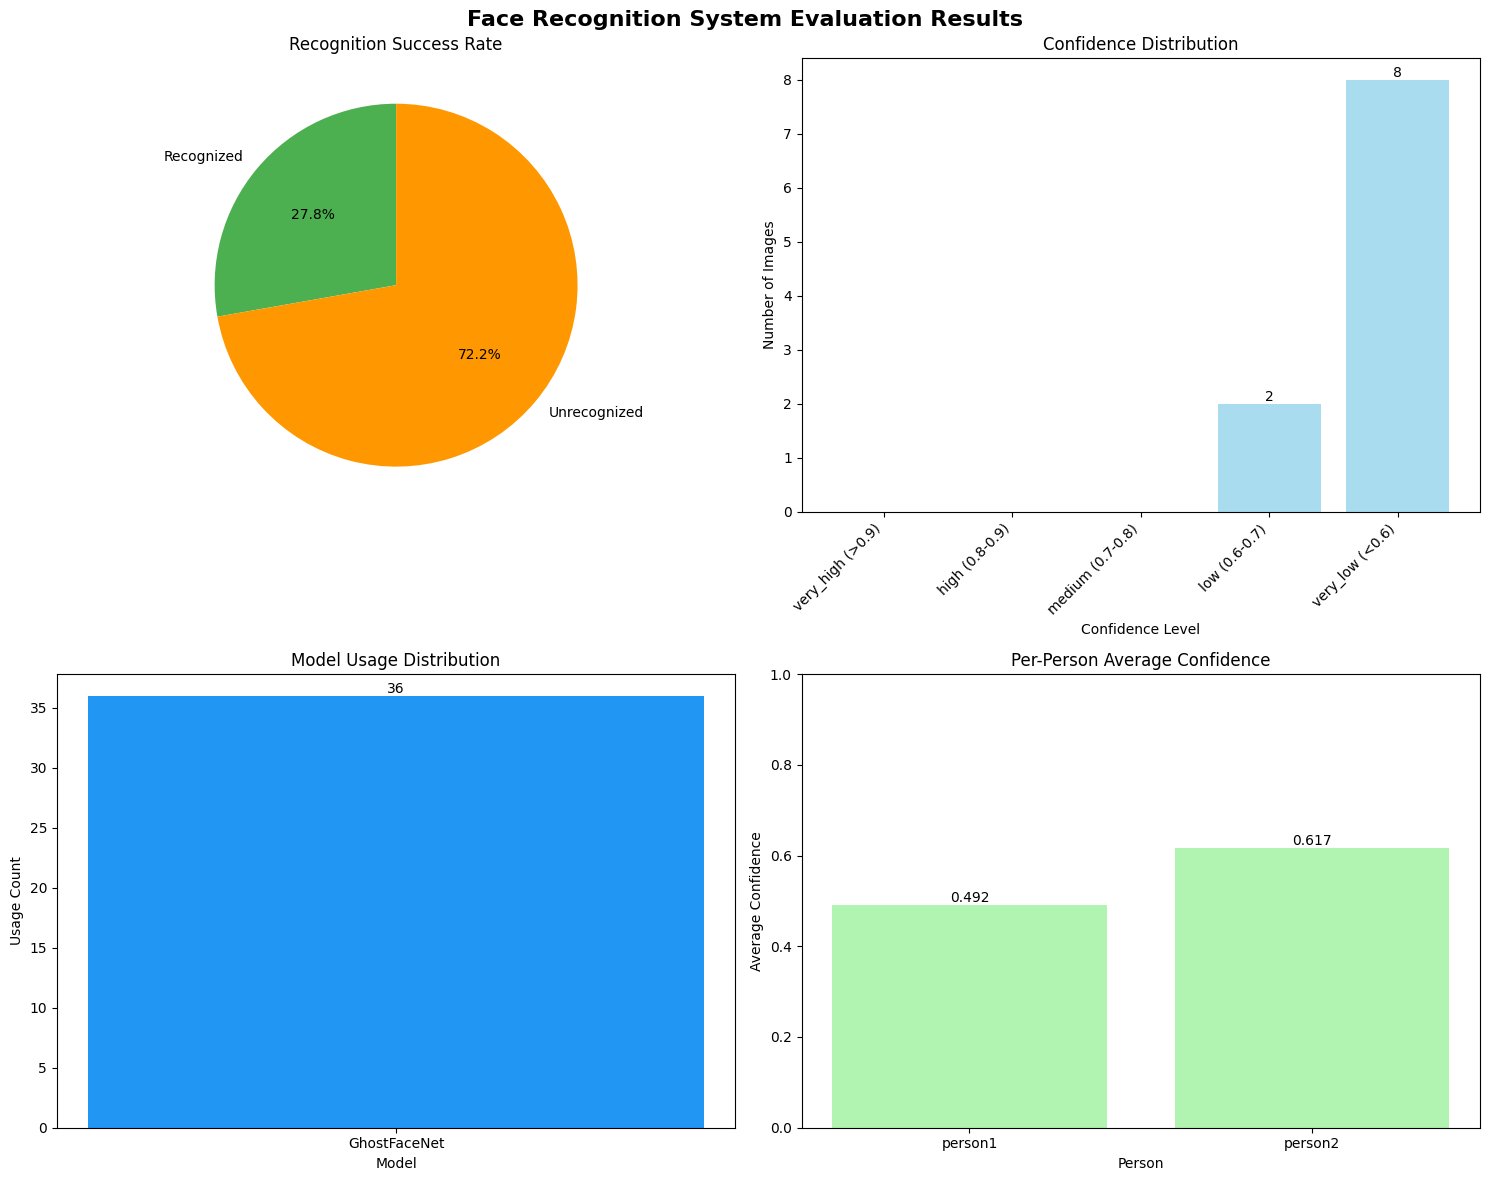

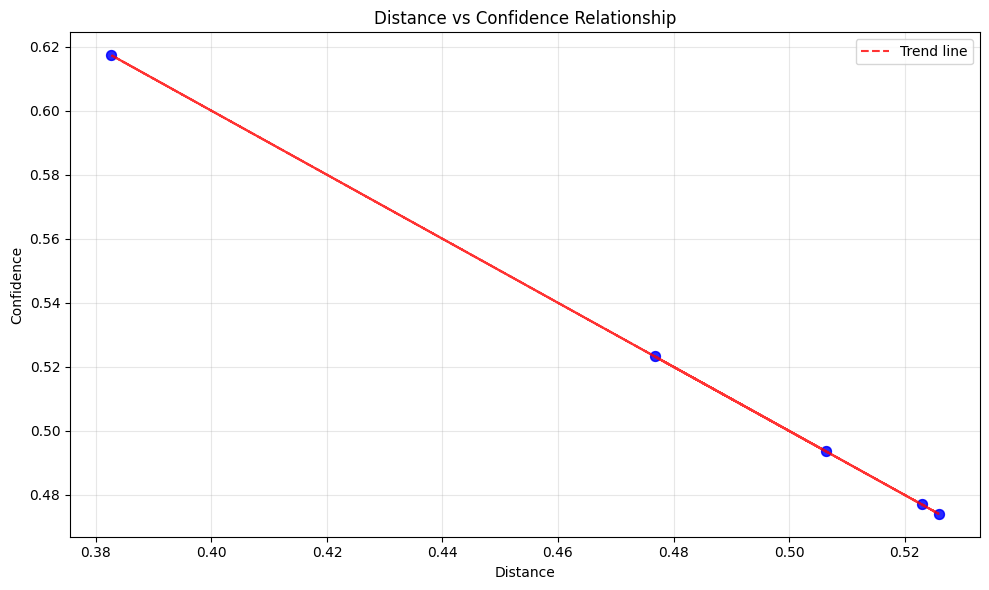

\n📋 DETAILED RESULTS (Top 10):
----------------------------------------------------------------------------------------------------
 1. covAA-04.jpg                   → person2    (Conf: 0.617, Dist: 0.383, Model: GhostFaceNet)
 2. covAA-04.jpg                   → person2    (Conf: 0.617, Dist: 0.383, Model: GhostFaceNet)
 3. 20250708_162645.jpg            → person1    (Conf: 0.523, Dist: 0.477, Model: GhostFaceNet)
 4. 20250708_162645.jpg            → person1    (Conf: 0.523, Dist: 0.477, Model: GhostFaceNet)
 5. 20250701_182222.jpg            → person1    (Conf: 0.494, Dist: 0.506, Model: GhostFaceNet)
 6. 20250701_182222.jpg            → person1    (Conf: 0.494, Dist: 0.506, Model: GhostFaceNet)
 7. 20250708_162657.jpg            → person1    (Conf: 0.477, Dist: 0.523, Model: GhostFaceNet)
 8. 20250708_162657.jpg            → person1    (Conf: 0.477, Dist: 0.523, Model: GhostFaceNet)
 9. 20250713_195431.jpg            → person1    (Conf: 0.474, Dist: 0.526, Model: GhostFaceNet)
10. 

In [24]:
# Final execution and visualization (if results are available)
if 'evaluation_summary' in globals():
    print("\\n=== GENERATING VISUALIZATIONS ===")
    
    # Create visualizations
    create_visualizations(evaluation_summary)
    
    # Display detailed results
    if 'recognition_results' in globals():
        display_detailed_results(recognition_results, max_results=10)
    
    # Export summary report
    summary_report = export_results_summary(evaluation_summary)
    
    # Save summary report
    with open("evaluation_report.txt", "w") as f:
        f.write(summary_report)
    
    print("\\n📄 SUMMARY REPORT:")
    print(summary_report)
    
else:
    print("\\n⚠️  No evaluation data available.")
    print("To run the complete pipeline:")
    print("1. Ensure your face_database folder contains person subdirectories with images")
    print("2. Ensure your sample_images folder contains query images")
    print("3. Run all cells in sequence")
    
    print("\\n📁 EXPECTED FOLDER STRUCTURE:")
    print("""
    face_database/
    ├── person1/
    │   ├── person1_1.jpg
    │   ├── person1_2.jpg
    │   └── person1_3.jpg
    ├── person2/
    │   ├── person2_1.jpg
    │   └── person2_2.jpg
    └── person3/
        ├── person3_1.jpg
        └── person3_2.jpg
    
    sample_images/
    ├── query1.jpg
    ├── query2.jpg
    └── subfolder/
        └── more_queries.jpg
    """)

## Quick Configuration Guide

### Easily Change Models and Algorithms

To modify the face recognition models and algorithms, update the `FaceRecognitionConfig` class:

```python
# Example: Change to different models
config.primary_model = "ArcFace"          # Options: VGG-Face, Facenet, OpenFace, DeepFace, DeepID, ArcFace, Dlib, SFace, GhostFaceNet
config.fallback_model = "VGG-Face"
config.primary_detector = "mediapipe"     # Options: opencv, ssd, dlib, mtcnn, retinaface, mediapipe
config.distance_metric = "euclidean"      # Options: cosine, euclidean, euclidean_l2
config.similarity_threshold = 0.4         # Adjust based on distance metric
```

### Key Features Implemented

✅ **Configurable Models**: Easy switching between GhostFaceNet, FaceNet, and other DeepFace models  
✅ **Robust Fallback**: Automatic fallback to secondary model if primary fails  
✅ **Face Alignment**: Automatic face alignment for better accuracy  
✅ **Image Augmentation**: Lighting variations to improve recognition robustness  
✅ **JSON Database**: Structured storage of embeddings and metadata  
✅ **Top-K Matching**: Configurable top-5 (or more) similarity matching  
✅ **Comprehensive Logging**: Detailed logs for debugging and evaluation  
✅ **Evaluation Metrics**: Recognition rates, confidence analysis, model performance  
✅ **Visualizations**: Charts and graphs for result analysis  

### Output Files Generated

- `face_embeddings_db.json`: Complete database with embeddings and metadata
- `recognition_results.json`: Detailed recognition results with all metrics
- `evaluation_report.txt`: Human-readable summary report